In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager

from base.timeutil import YearMonth
from core.repository import FinanceLoader
from core.repository.maria.conn import maria_home

# 월 차트 로드
print("Fetching month chart...")

begin = YearMonth(2002, 3)
end = YearMonth(2023, 7)

month_chart = pd.read_sql(
    f"""
    select month_chart.*, stock.name, stock.exchange from month_chart
    join stock on month_chart.code = stock.code
    """,
    maria_home()
)

print("Loading financial data...")
fin_loader = FinanceLoader()

# matplot 셋업
font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

Fetching month chart...
Loading financial data...


In [12]:
import pandas as pd
from base.timeutil import YearMonth, YearQuarter

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
# yms = pd.Series([ym for ym in yms if ym.month in [3, 5, 8, 11]] + [max(yms)])
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df1 = df1[df1["val_last"] >= 1000_0000]
    df2.loc[df2["val_last"] == 0, "close"] = df2[df2["val_last"] == 0]["close"] / 2

    df = pd.DataFrame({
        "종목명": df1["name"], "거래소": df1["exchange"],
        "매수년월": ym1, "매도년월": ym2,
        "매수일": df1["date"], "매수가": df1["close"],
        "시가총액": df1["cap"], "거래량": df1["vol"], "거래대금": df1["val"],
        "전월수익률": df1["close"] / df1["open"] - 1
    })

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거

    df["매도가"] = df2["close"]
    df["매도일"] = df2["date"]
    df["수익률"] = df["매도가"] / df["매수가"] - 1
    # 재무데이터 조인하여 layer1에 반영
    fn = fin_loader.load(YearQuarter.last_confirmed(ym1.year, ym1.month))
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1

,code,종목명,거래소,매수년월,매도년월,매수일,매수가,시가총액,거래량,거래대금,...,O_QoQA,E_QoQA,R/A_QoQ,R/EQ_QoQ,GP/A_QoQ,GP/EQ_QoQ,O/A_QoQ,O/EQ_QoQ,E/A_QoQ,E/EQ_QoQ
0,006840,AK홀딩스,유가증권,2002-03,2002-04,2002-03-29,22200,133200000000,1040677,23138436200,...,-1396.665901,-1.192408,0.014648,0.059257,0.006325,0.014589,0.005541,0.010427,0.002395,0.004638
1,054620,APS,코스닥,2002-03,2002-04,2002-03-29,14200,34932000000,6031167,71079147610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001460,BYC,유가증권,2002-03,2002-04,2002-03-29,74500,46533817500,75750,5045230000,...,0.852411,0.748491,-0.022395,-0.034642,0.001063,0.000234,0.007600,0.009817,0.007389,0.009563
3,001465,BYC우,유가증권,2002-03,2002-04,2002-03-29,34750,7484628750,24157,807656500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,013720,CBI,코스닥,2002-03,2002-04,2002-03-29,4310,8634330750,919289,3492197440,...,-0.672843,-0.865784,0.006120,-0.058039,0.000558,-0.014141,0.001388,-0.002596,-0.003132,-0.008196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394613,189980,흥국에프엔비,코스닥,2023-06,2023-07,2023-06-30,2835,113790739545,5367732,16340191270,...,4.103340,-15.727934,-0.017821,0.039274,-0.006023,0.013537,0.005283,0.017027,0.002922,0.010228
394614,000540,흥국화재,유가증권,2023-06,2023-07,2023-06-30,3155,202685544975,1283095,4085555555,...,-5.708213,-12.721524,-0.004562,-1.129165,NaN,NaN,0.006684,-0.004460,0.005024,-0.006967
394615,003280,흥아해운,유가증권,2023-06,2023-07,2023-06-30,2100,504892287900,159894770,327193558893,...,1.387153,2.730592,0.044109,0.058857,0.028347,0.057952,0.020031,0.041599,0.018313,0.038572
394616,037440,희림,코스닥,2023-06,2023-07,2023-06-30,8400,116948790000,5025556,45833419310,...,-0.010596,0.989113,-0.023639,-0.011178,-0.002336,-0.000317,-0.002773,-0.005488,0.001033,0.004401


In [13]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
    }
)

factors = [
    "R/Y", "GP/Y", "O/Y", "E/Y",
    "P"
]


def add_factor(name, data=None):
    factors.append(name)
    if data is not None:
        layer2[name] = data


for col in layer2.columns:
    if "QoQ" in col:
        add_factor(col)

for x in ["R/Y", "GP/Y", "O/Y", "E/Y"]:
    for y in ["A", "EQ"]:
        add_factor(f"{x}/{y}", layer2[x] / layer2[y])

add_factor("GP/P", layer2["GP/Y"] / layer2["P"])
add_factor("EQ/P", layer2["EQ"] / layer2["P"])

recipes = {
    "v3": {
        "P": -8,
        "GP/P": 4,
        "EQ/P": 4,
        "R_QoQ": 1,
        "GP_QoQ": 1,
        "O_QoQ": 1,
        "E_QoQ": 1,
        "R/A_QoQ": 1,
        "GP/A_QoQ": 1,
        "O/A_QoQ": 1,
        "E/A_QoQ": 1
    },
    "성장_단순이익": {f"{e}_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_자산대비이익": {f"{e}/A_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_자본대비이익": {f"{e}/EQ_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_매출종합": {f"R{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_매출총이익종합": {f"GP{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_영업이익종합": {f"O{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_순이익종합": {f"E{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장": {
        "성장_매출총이익종합": 5,
        "성장_영업이익종합": 4,
        "성장_순이익종합": 3,
        "성장_매출종합": 2,
    },
    "벨류": {
        "GP/P": 1,
        "EQ/P": 1,
    },
    "v4": {
        "P": -1,
        "성장": 1,
        "벨류": 1,
    },
    "전략": {
        "v3": 1,
        "v4": 1
    }
}

result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

    for title, recipe in recipes.items():
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else -df[f"{k}_pct"] * abs(w) for k, w in recipe.items()])

        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[title] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

result

2023-07

,code,종목명,거래소,매수년월,매도년월,매수일,매수가,P,거래량,TV,...,성장_순이익종합,성장_순이익종합_pct,성장,성장_pct,벨류,벨류_pct,v4,v4_pct,전략,전략_pct
0,006840,AK홀딩스,유가증권,2002-03,2002-04,2002-03-29,22200,133200000000,1040677,23138436200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,054620,APS,코스닥,2002-03,2002-04,2002-03-29,14200,34932000000,6031167,71079147610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001460,BYC,유가증권,2002-03,2002-04,2002-03-29,74500,46533817500,75750,5045230000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001465,BYC우,유가증권,2002-03,2002-04,2002-03-29,34750,7484628750,24157,807656500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,013720,CBI,코스닥,2002-03,2002-04,2002-03-29,4310,8634330750,919289,3492197440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394613,189980,흥국에프엔비,코스닥,2023-06,2023-07,2023-06-30,2835,113790739545,5367732,16340191270,...,74.000000,73.0,71.714286,76.0,57.0,59.0,30.666667,78.0,76.5,77.0
394614,000540,흥국화재,유가증권,2023-06,2023-07,2023-06-30,3155,202685544975,1283095,4085555555,...,65.666667,64.0,NaN,NaN,51.5,53.0,NaN,NaN,NaN,NaN
394615,003280,흥아해운,유가증권,2023-06,2023-07,2023-06-30,2100,504892287900,159894770,327193558893,...,91.000000,93.0,95.285714,98.0,24.0,18.0,11.000000,36.0,36.0,36.0
394616,037440,희림,코스닥,2023-06,2023-07,2023-06-30,8400,116948790000,5025556,45833419310,...,63.333333,63.0,55.285714,57.0,45.0,43.0,18.666667,52.0,51.5,51.0


['v3', '성장_단순이익', '성장_자산대비이익', '성장_자본대비이익', '성장_매출종합', '성장_매출총이익종합', '성장_영업이익종합', '성장_순이익종합', '성장', '벨류', 'v4', '전략']
[3/3] 전략
2002-03 2023-07
             v3  성장_단순이익  성장_자산대비이익  성장_자본대비이익  성장_매출종합  성장_매출총이익종합  \
P          -8.0      NaN        NaN        NaN      NaN         NaN   
GP/P        4.0      NaN        NaN        NaN      NaN         NaN   
EQ/P        4.0      NaN        NaN        NaN      NaN         NaN   
R_QoQ       1.0      1.0        NaN        NaN      1.0         NaN   
GP_QoQ      1.0      1.0        NaN        NaN      NaN         1.0   
O_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
E_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
R/A_QoQ     1.0      NaN        1.0        NaN      1.0         NaN   
GP/A_QoQ    1.0      NaN        1.0        NaN      NaN         1.0   
O/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
E/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
R/EQ_

,spearman,kendall,h3,h5,h10,t3,t5,t10,mdd5,h3-t3,h10-t10,h3-t3+mdd3,h10-t10+mdd10,mean,median
성장,0.899898,0.731313,0.201961,0.208288,0.214055,-0.083548,-0.078492,-0.052227,-0.576800,0.285509,0.266281,-0.273900,-0.309326,0.090598,0.097327
벨류,0.944902,0.806061,0.273524,0.258673,0.248557,-0.200500,-0.178570,-0.138429,-0.538796,0.474024,0.386985,-0.082878,-0.158138,0.085688,0.100822
전략,0.966469,0.850101,0.491859,0.452534,0.415792,-0.179129,-0.154643,-0.127850,-0.510968,0.670987,0.543642,0.166131,0.023030,0.096784,0.071727


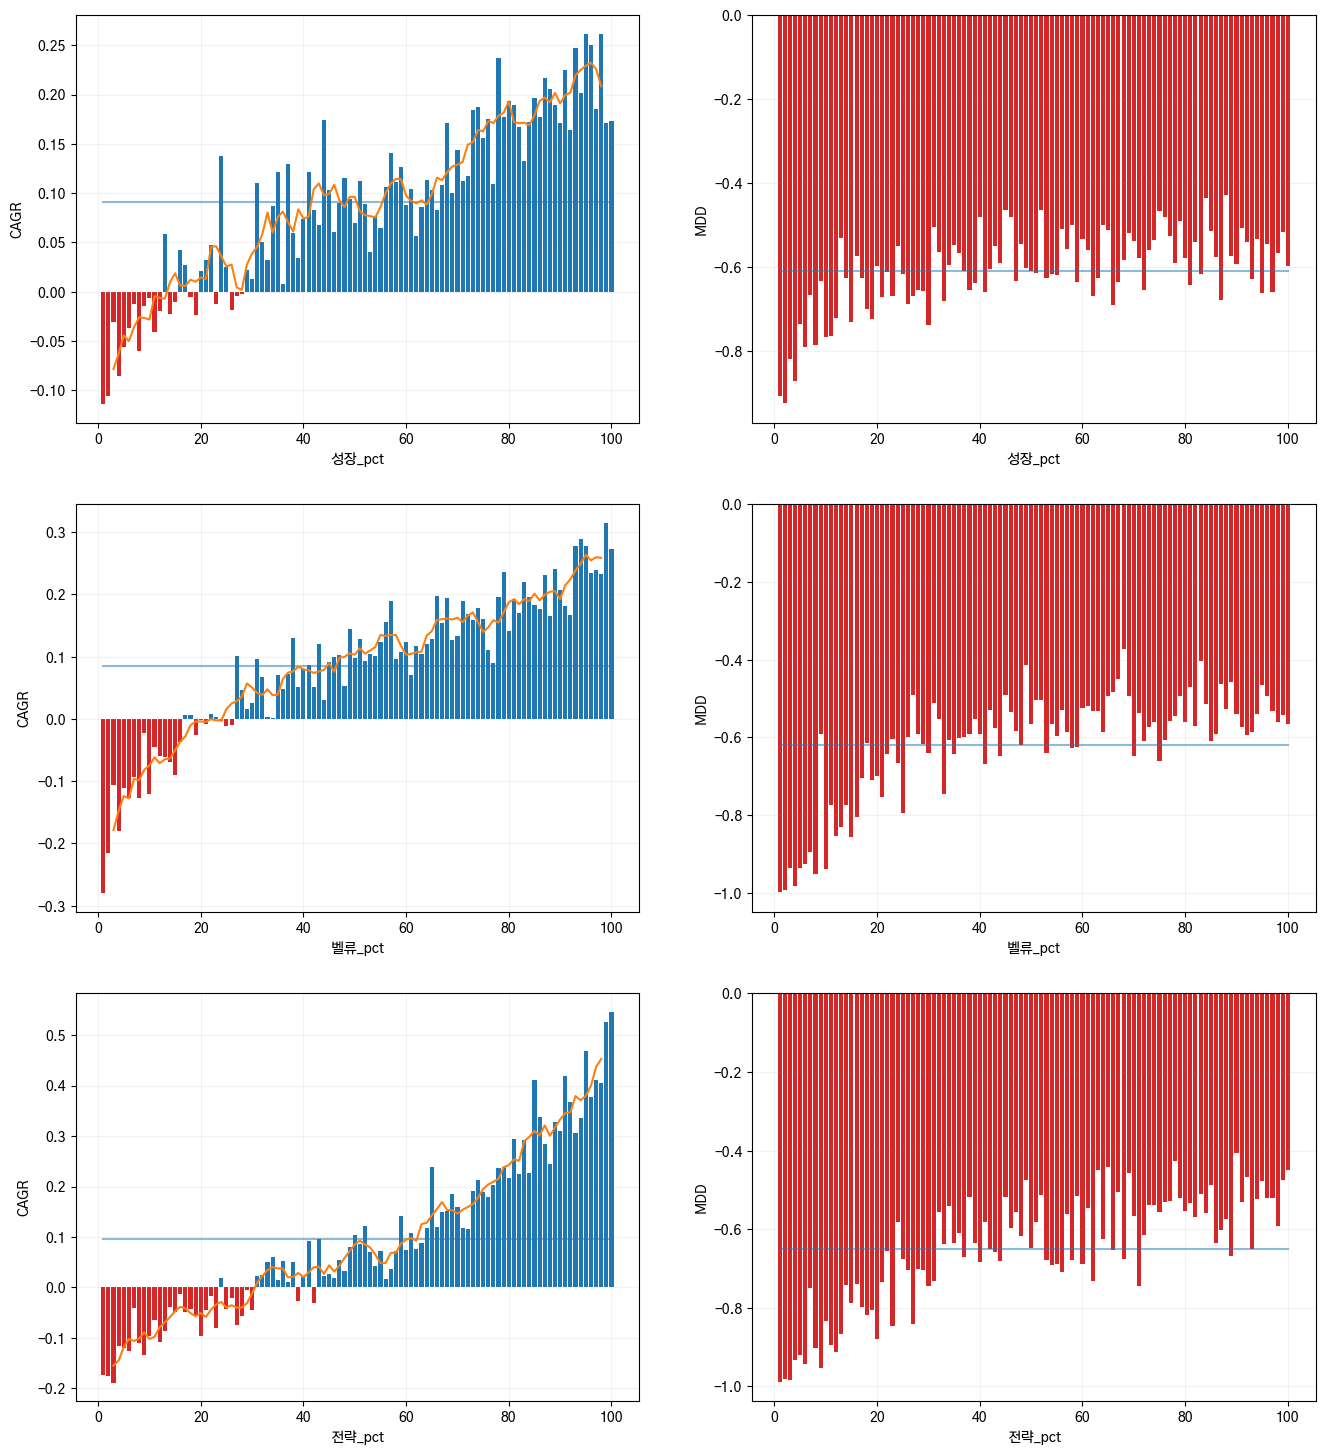

In [14]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

import matplotlib.pyplot as plt

from core.base.quantutil import cagr, mdd

target_factors = list(recipes.keys())
print(target_factors)
target_factors = ["성장", "벨류", "전략"]

fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date() for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    spearman = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname_pct]["cagr"],
            "kendall": kendall[colname_pct]["cagr"],
            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t3": cagr_by_pct_desc.tail(3).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
            "h3-t3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "h3-t3+mdd3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean() + mdd_by_pct_desc.head(
                3).mean(),
            "h10-t10+mdd10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean() + mdd_by_pct_desc.head(
                10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])

fig.savefig('test.png', bbox_inches='tight')

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))
summary